### Data Loading and Preparation 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
import fbprophet
from fbprophet import Prophet
import os
print(os.listdir())


['.ipynb_checkpoints', 'Case Retrieval with DTW K-NN.ipynb', 'Data Loadiing and Preparation.ipynb', 'features.csv', 'Prophet Forecast & Data Augmentation.ipynb', 'Sales_Data.csv', 'Sales_Data_.csv', 'sampleSubmission.csv', 'stores.csv', 'Stores_NN.csv', 'test.csv', 'train.csv', 'Training_Sales_Data.csv']


In [2]:
dataset = pd.read_csv("train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')

dataset

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
5,1,1,2010-03-12,21043.39,False,A,151315,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106
6,1,1,2010-03-19,22136.64,False,A,151315,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106
7,1,1,2010-03-26,26229.21,False,A,151315,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106
8,1,1,2010-04-02,57258.43,False,A,151315,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808
9,1,1,2010-04-09,42960.91,False,A,151315,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808


In [3]:
dataset = pd.get_dummies(dataset, columns=["Type"])
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Date'] = pd.to_datetime(dataset['Date'])
#dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])
dataset.head(5)

,Store,Dept,Date,weeklySales,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_A,Type_B,Type_C,Month
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0,0,2
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,1,0,0,2
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,1,0,0,2
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,1,0,0,2
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,1,0,0,3


In [4]:
dataset.index=dataset['Date']

### Getting More Features from the Date

In [5]:
dataset['Week']=dataset.index.week
len(dataset.Store.unique())

45

In [6]:
dataset.Week.unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  1,  2,  3,
        4], dtype=int64)

In [7]:
dataset['Year'] = dataset.index.year
dataset.Year.unique()

array([2010, 2011, 2012], dtype=int64)

In [8]:
dataset.columns

Index(['Store', 'Dept', 'Date', 'weeklySales', 'isHoliday', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type_A', 'Type_B',
       'Type_C', 'Month', 'Week', 'Year'],
      dtype='object')

In [9]:
grouper = dataset.groupby(['Store', 'Week', 'Year'])

### Resampling

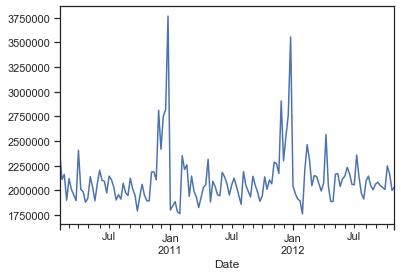

In [10]:
pd.plotting.register_matplotlib_converters()
dataset[dataset['Store'] ==20]['weeklySales'].resample('1W').sum().plot()

In [11]:
store_id = []
weekly_sales = []
weekly_cpi = []
weekly_unemployment = []
store_size = []
date = []

#for store in range(len(dataset['Store'].unique())):
for store in range(1,46):

    date.append(dataset[dataset['Store'] ==store].resample('1W').mean().index)
    store_id.append(dataset[dataset['Store'] ==store]['Store'].resample('1W').mean().values)
    weekly_sales.append(dataset[dataset['Store'] == store]['weeklySales'].resample('1W').sum().values)
    weekly_unemployment.append(dataset[dataset['Store'] ==store]['Unemployment'].resample('1W').mean().values)
    store_size.append(dataset[dataset['Store'] ==store]['Size'].resample('1W').mean().values)
    weekly_cpi.append(dataset[dataset['Store'] ==store]['CPI'].resample('1W').mean().values)

In [12]:
store_id = [item for sublist in store_id for item in sublist]
weekly_sales = [item for sublist in weekly_sales for item in sublist]
weekly_cpi = [item for sublist in weekly_cpi for item in sublist]
date = [item for sublist in date for item in sublist]
store_size = [item for sublist in store_size for item in sublist]

In [13]:
data = zip(store_id,store_size,weekly_sales)

In [14]:
df = pd.DataFrame(data, index=date)
df.columns = ['Store_ID','Store_Size','Weekly_Sales']

### Visualising Sales

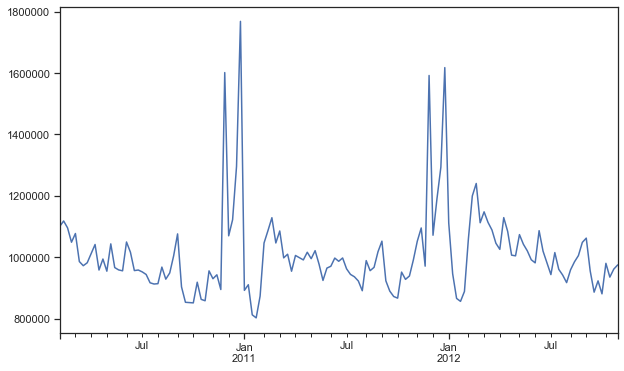

In [15]:
df[df['Store_ID']==12]['Weekly_Sales'].plot(figsize=(10,6)) #show the sales for stor number 12

In [16]:
df.head()

,Store_ID,Store_Size,Weekly_Sales
2010-02-07,1,151315,1643690.90
2010-02-14,1,151315,1641957.44
2010-02-21,1,151315,1611968.17
2010-02-28,1,151315,1409727.59
2010-03-07,1,151315,1554806.68


### Splitting weekly data into Training and Testing Data for 6 Month Forecasts

In [17]:
df_train = df[df.index < '2012-05-20']
df_test = df[df.index >= '2012-05-20']

In [18]:
print('Training set has %s weeks of data' %(len(df_train[df_train['Store_ID']==2])))
print('Test set had %s weeks of data' %(len(df_test[df_test['Store_ID']==2])))

Training set has 119 weeks of data
Test set had 24 weeks of data


### Normalization

This is implemented for the purpose of the NN search. Note we can only normalize the training data as we dont know the values of the future (test data).

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
#scaler = MinMaxScaler()  if we want to implement min max normalization

Normalized_Weekly_Sales = scaler.fit_transform(df_train[['Weekly_Sales']])
Normalized_Weekly_Sales = Normalized_Weekly_Sales[:,0]
df_train['Normalized_Weekly_Sales'] =Normalized_Weekly_Sales

C:\Users\eoind\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



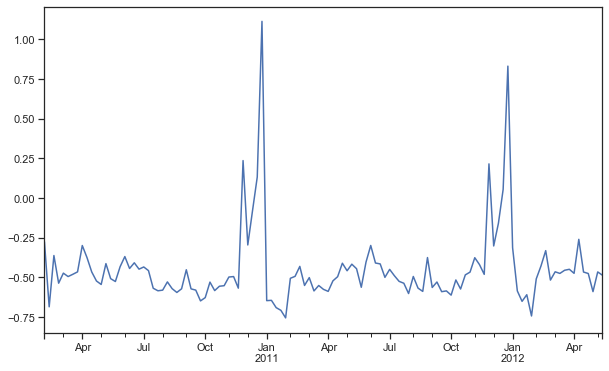

In [20]:
df_train[df_train['Store_ID']==45]['Normalized_Weekly_Sales'].plot(figsize=(10,6))

In [21]:
df_train.to_csv('Training_Sales_Data.csv')

In [22]:
df.to_csv('Sales_Data_.csv')